# OFDM with QAM Modulation - Transmitter

Bit stream -> M-QAM -> OFDM -> Noise -> Visualizations 



In [46]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat

ifft_size = 720 # FFT size = number of subcarriers 
cp_length = 80
num_symbols = 20
mod_order = 16 # modulation order (e.g., 16-QAM)
num_active = 109 # number of active subcarriers 

Ld = ifft_size
Ls = Ld + cp_length 
dc_index = ifft_size // 2 
half = num_active // 2
active_subcarriers = np.arange(dc_index - half, dc_index + half + 1)
active_subcarriers = active_subcarriers[active_subcarriers != dc_index]

ifft_size = 720: This determines the total number of subcarriers (both active and inactive) in each OFDM symbol. 

You can think of this as the size of your frequency grid — you have 720 "slots" in the frequency domain.

cp_length = 80: Length of the cyclic prefix added to each OFDM symbol (used to combat ISI).

num_symbols = 20: This refers to the number of OFDM time-domain symbols you generate in total — i.e., how many different time samples (each one made from 720 subcarriers) you will create.

M-QAM: This tells us that each active subcarrier carries \(log_2(M)\) bits per OFDM symbol 

Think of it like a matrix:

- Each row is an OFDM symbol in time (20 total).
- Each column is a subcarrier (720 total, but maybe only ~109 are "active").

So we have 

$[720 subcarriers × 20 symbols]$

structure before applying IFFT + CP.

Each OFDM symbol uses the full set of subcarriers (but not all need to be modulated — often you zero-out the edges or DC).

Why 109 active subcarriers? 

The choice of 109 active subcarriers is arbitrary and design-dependent — it's not fixed by the IFFT size (720).

Even though your IFFT size is 720, not all subcarriers are used for data transmission.

DC Subcarrier (Center Frequency): The subcarrier at index 720/2 +1 = 361, corresponds to 0 Hz (DC), it is not used because it causes interference and no information is transmitted at 0 Hz.

Guard Bands: Subcarriers at the edges of the IFFT spectrum are usually zero-padded (i.e., set to 0) to prevent spectral leakage and simplify filtering. These are called guard subcarriers. This is especially important when OFDM signals are adjacent to other channels (e.g., LTE or WiFi).

Pilot Subcarriers (optional): Some subcarriers are used for channel estimation and synchronization — they don't carry data but help the receiver align and equalize.

\begin{array}{|l|c|l|}
\hline
\textbf{Region} & \textbf{Subcarrier Indices} & \textbf{Purpose} \\
\hline
\text{1. Guard (left)} & 1\text{ to }306 & \text{Zero-padded (guard)} \\
\text{2. Active (lower)} & 307\text{ to }360 & \text{QPSK data} \\
\text{3. DC} & 361 & \text{Explicitly nulled} \\
\text{4. Active (upper)} & 362\text{ to }415 & \text{QPSK data} \\
\text{5. Guard (right)} & 416\text{ to }720 & \text{Zero-padded (guard)} \\
\hline
\end{array}





### General M-QAM Mapping 

#### M-QAM Mapping

In **square M-QAM**, the constellation is a square grid:

* For **16-QAM**, the grid is $4 \times 4$
* For **64-QAM**, it's $8 \times 8$

That means:

* Half the bits control the **in-phase (I)** component
* Half control the **quadrature (Q)** component


#### 1. `bits_per_axis = bits_per_symbol // 2`

This divides the total bits per symbol equally between the **I** and **Q** axes.

| Modulation | bits\_per\_symbol | bits\_per\_axis |
| ---------- | ----------------- | --------------- |
| QPSK (4)   | 2                 | 1               |
| 16-QAM     | 4                 | 2               |
| 64-QAM     | 6                 | 3               |

So:

* Each **QAM symbol** = `bits_per_symbol` bits
* $2^{\text{bits\_per\_axis}}$ levels per axis


#### 2. `M_axis = sqrt(mod_order)`

This calculates the number of levels **per dimension** in the constellation.

| mod\_order | M\_axis |
| ---------- | ------- |
| 4          | 2       |
| 16         | 4       |
| 64         | 8       |

So for 16-QAM, each axis (I/Q) has 4 possible values (e.g., $-3, -1, +1, +3$)

---

#### 3. Splitting Bits into I and Q

```python
bits_I = symbols_bin[:, :bits_per_axis]   # First half of bits
bits_Q = symbols_bin[:, bits_per_axis:]   # Second half of bits
```

We're taking the `symbols_bin` matrix (shape: `[num_symbols, bits_per_symbol]`), and for each row:

* The **first half** goes to `bits_I`
* The **second half** goes to `bits_Q`

These are used to modulate:

* I: horizontal axis of constellation (real part)
* Q: vertical axis (imaginary part)

---

#### Example: 16-QAM

For one QAM symbol:

```python
bits = [1, 0, 1, 1]
```

```python
bits_I = [1, 0] → decimal 2 → I component
bits_Q = [1, 1] → decimal 3 → Q component
```

Then mapped to:

* $I = 2 \times 2 - 3 = +1$
* $Q = 2 \times 3 - 3 = +3$

Final complex symbol:

```python
qam_data = 1 + j*3
```



In [47]:
def generate_mqam_symbols(mod_order, num_active, num_symbols):
    
    bits_per_symbol = int(np.log2(mod_order))
    total_bits = num_active * num_symbols * bits_per_symbol
    bits = np.random.randint(0,2,total_bits) # generate random bits [low = 0, high = 2) = [0,1]
    symbol_bin = bits.reshape(-1,bits_per_symbol) # e.g, 4360 bits will be (1090,4) if log2(M) = 4
    # reshape(-1,x), automatically figures out how many rows are needed so each row has x columns 
    # QAM parameters: 
    bits_per_axis = bits_per_symbol // 2   # divide bits equally for I & Q
    M_axis = int(np.sqrt(mod_order)) # number of constellation points per axis 
    # split bits into I, Q parts: 
    bits_I = symbol_bin[:, :bits_per_axis] # Take I bits from each row 
    bits_Q = symbol_bin[:, bits_per_axis:] # Takes Q bits from each row 

    # Converting each row of array of binary bits into decimal (integer) value similar to bi2de() in matlab 
    def bin2dec(arr): 
        return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
    
    I_indices = bin2dec(bits_I)
    Q_indices = bin2dec(bits_Q) 

    # Map to constellation points
    I_vals = 2*I_indices - (M_axis - 1)
    Q_vals = 2*Q_indices - (M_axis - 1)

    qam_data = I_vals + 1j*Q_vals 
    qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

    return qam_data, bits 
    

In [48]:
qam_data, bits = generate_mqam_symbols(mod_order, num_active, num_symbols)
print("QAM symbols shape:", qam_data.shape)  

QAM symbols shape: (2180,)


#### Further Steps: 

1. Bit Stream Generation

2. Modulation groups every 2 bits → 1 complex symbol, Output: A stream of complex symbols.

3. Serial to parallel conversion:

    - Divide the complex symbol stream into blocks of size equal to the number of active subcarriers (e.g., 109).

    - These form frequency-domain vectors for each OFDM symbol.

4. Subcarrier mapping: 
Map each block of complex symbols to specific active subcarriers in the full IFFT grid (e.g., 720-point vector). Set unused subcarriers and DC to 0.

5. IFFT: Apply IFFT (e.g., 720-point) to each frequency-domain OFDM symbol to convert it into a time-domain signal.
Output: time-domain complex samples for each OFDM symbol.

6. Cyclic Prefix (CP) Addition: 
Copy the last cp_length samples of the IFFT output and prepend them to the symbol.
This helps with multipath channel resilience.

7. Parallel-to-Serial Conversion

    - Convert the CP-added symbols back into a serial stream for DAC transmission.
    OFDM Signal generation

    - OFDM divides the total channel bandwidth into multiple orthogonal subcarriers. Each subcarrier carries a portion of the data in parallel, making the system resilient to multipath fading and ISI.

Let:

    N: IFFT size (number of subcarriers)
    X[k]: Modulated symbol (e.g., QPSK, M-QAM) on the k-th subcarrier
    x[n]: Time-domain OFDM signal

$$x[n] = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} X[k] \cdot e^{j\, \frac{2\,\pi \,k\,n}{N}}, \quad n = 0, 1, \dots, N-1
$$

Subcarrier Allocation and DC Nulling

Active subcarriers are chosen symmetrically around the center.

The DC subcarrier (at k = N/2) is set to zero to eliminate carrier leakage.

Guard bands are left unused to avoid spectral leakage into adjacent channels.

To combat Inter-Symbol Interference (ISI), a Cyclic Prefix of length  is added by copying the last samples of the time-domain symbol and appending them to the front.

$$
x_{\text{cp}}[n] =
\begin{cases}
x[n + N - L_{\text{CP}}], & 0 \leq n < L_{\text{CP}} \\
x[n - L_{\text{CP}}], & L_{\text{CP}} \leq n < N + L_{\text{CP}}
\end{cases}
$$

The total OFDM symbol length becomes 

$$L_s = N + L_{\text{CP}}
$$

The transmit signal is constructed by concatenating multiple CP-extended OFDM symbols:

$$x_{\text{total}}[n] = \left[ \text{CP}_1 + x_1[n],\ \text{CP}_2 + x_2[n],\ \dots \right]
$$

OFDM transmits data in parallel over multiple subcarriers, each modulated at a different frequency. It uses the orthogonality of sinusoids to pack them tightly together without interference.

BUT: generating multiple sinusoids manually would be complex.

Instead of manually modulating 109 carriers with QPSK and summing sinusoids, we use the Inverse Fast Fourier Transform (IFFT).

Each point in the frequency-domain vector you pass to the IFFT acts like the amplitude/phase of a subcarrier.

The IFFT outputs a superposition of all those subcarriers — a time-domain signal.

Think of OFDM as encoding frequency data, and then IFFT transforms it into the real-world time signal you transmit.



In [49]:
def generate_ofdm_signal(qam_data,ifft_size, cp_length,num_symbols,active_subcarriers, dc_index):
    num_active = len(active_subcarriers)
    symbol_matrix = np.zeros((num_symbols,ifft_size),dtype = complex)
    ofdm_signal = []

    for i in range(num_symbols):
        freq_data = np.zeros(ifft_size, dtype = complex)
        idx_start = i * num_active 
        idx_end = (i + 1)*num_active 
        this_symbol = qam_data[idx_start:idx_end]
        # Mapping QAM symbols to active subcarriers 
        freq_data[active_subcarriers] = this_symbol 
        freq_data[dc_index] = 0 #ensure dc is zeroed 
        symbol_matrix[i,:] = freq_data
        time_data = np.fft.ifft(np.fft.ifftshift(freq_data))*np.sqrt(ifft_size)
        cp = time_data[-cp_length:]
        ofdm_symbol = np.concatenate((cp,time_data))
        ofdm_signal.append(ofdm_symbol)
    
    # faltten to 1D signal 
    ofdm_signal = np.concatenate(ofdm_signal)
    #normalize to unit power 
    ofdm_signal = ofdm_signal / np.sqrt(np.mean(np.abs(ofdm_signal)**2))

    return ofdm_signal, symbol_matrix 


In [50]:
ofdm_signal, symbol_matrix = generate_ofdm_signal(
    qam_data=qam_data,
    ifft_size=720,
    cp_length=80,
    num_symbols=20,
    active_subcarriers=[i for i in range(720) if i != 360][-109:],  # Example: last 109 excluding DC
    dc_index=360
)

Note: 
At this point, we have a baseband complex-valued signal, which is:

$$s_{\text{baseband}} (t) = I(t) + jQ(t)$$

To transmit it over a real-valued RF channel, we need to convert it to a passband (RF) signal using IQ modulation:

IQ Modulation (Digital-to-Analog + RF Upconversion): 

generate the real RF signal as:

$$s(t) = I(t) . cos(2\pi\, f_c t) - Q(t) . sin(2\pi f_ct)
$$

This maps the complex baseband signal to a real-valued RF signal centered at carrier frequency 

#### Noise Modeling: Additive White Gaussian Noise (AWGN)

AWGN simulates channel impairments. It is added with a controlled Signal-to-Noise Ratio (SNR):

Target SNR in dB:

$$SNR_{\text{dB}} = 10 \log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
$$

Convert to linear scale:

$$SNR_{\text{linear}} = 10^{\text{SNR}_{\text{dB}}/10}
$$

Noise power:

$$P_{\text{noise}} = \frac{P_{\text{signal}}}{\text{SNR}_{\text{linear}}}
$$

AWGN samples:

$$w[n] = \sqrt{\frac{P_{\text{noise}}}{2}} \cdot \left( \mathcal{N}(0,1) + j \mathcal{N}(0,1) \right)
$$

Final noisy signal:

$$x_{\text{noisy}}[n] = x_{\text{total}}[n] + w[n]
$$

#### Noise Padding

To emulate practical signal capture scenarios (e.g., over-the-air or burst transmissions), noise-only regions are added before and after the useful signal.

$$x_{\text{final}}[n] = \left[ w_{\text{before}},\ x_{\text{noisy}}[n],\ w_{\text{after}} \right]
$$

This helps in testing synchronization, thresholding, and signal detection techniques.



In [64]:
def add_noise_and_pad(ofdm_signal, noise_snr_db=35, left_pad=600, right_pad=1000, save_path='OFDM_Rx_Signal.mat'):
    # Step 1: Compute signal power and noise power
    signal_power = np.mean(np.abs(ofdm_signal)**2)
    noise_power = signal_power / (10**(noise_snr_db / 10))

    # Step 2: Add complex Gaussian noise (broadband in-band)
    noise_std = np.sqrt(noise_power / 2)
    inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
    ofdm_signal_noisy = ofdm_signal + inband_noise

    # Step 3: Add noise padding
    noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
    noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))

    # Step 4: Final concatenated signal
    final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])

    # Step 5: Save to .mat file
    savemat(save_path, {'final_signal': final_signal})

    return final_signal


In [65]:
final_signal = add_noise_and_pad(ofdm_signal, noise_snr_db=10, left_pad=600, right_pad=1000)


### Visualization 

In [53]:
def ofdm_demodulate(ofdm_signal_noisy, ifft_size, cp_length):
    Ld = ifft_size
    Ls = Ld + cp_length
    num_symbols_actual = len(ofdm_signal_noisy) // Ls

    # Step 1: Reshape the noisy signal into symbols
    X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))

    # Step 2: Remove CP
    X_no_cp = X_matrix[:, cp_length:]  # shape: [num_symbols, Ld]

    # Step 3: FFT and shift
    X_fft = np.fft.fftshift(np.fft.fft(X_no_cp, axis=1), axes=1)  # shape: [num_symbols, Ld]

    # Step 4: Power matrix
    power_matrix = np.abs(X_fft) ** 2  # shape: [num_symbols, Ld]

    # Step 5 (Optional): Pad to full IFFT size if Ld < ifft_size
    full_power = np.zeros((num_symbols_actual, ifft_size))
    full_power[:, :Ld] = power_matrix

    return full_power, X_fft, power_matrix


In [66]:
full_power, X_fft, power_matrix = ofdm_demodulate(
    ofdm_signal_noisy=final_signal[600:-1000],  # remove the noise padding before/after
    ifft_size=720,
    cp_length=80
)

Text(0.5, 1.0, 'Received OFDM Signal with Noise')

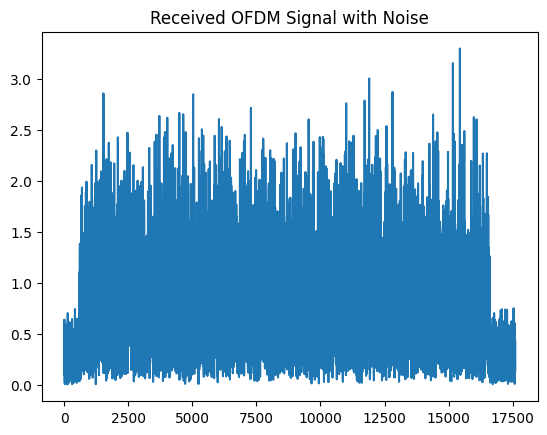

In [67]:
plt.figure(1) 
plt.plot(abs(final_signal))
plt.title('Received OFDM Signal with Noise')

In [68]:
def plot_subcarrier_power_improved(power_matrix, ifft_size, num_symbols_actual):
    power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)

    plt.figure(figsize=(12, 5))
    extent = [0, num_symbols_actual, 0, ifft_size]

    # Use jet colormap for better contrast
    im = plt.imshow(
        power_db.T,
        aspect='auto',
        extent=extent,
        origin='lower',
        cmap='jet',
        vmin=np.max(power_db) - 40,
        vmax=np.max(power_db)
    )

    plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
    plt.xlabel('OFDM Symbol Index', fontsize=12)
    plt.ylabel('Subcarrier Index', fontsize=12)
    plt.colorbar(im, label='Power (dB)')

    plt.grid(False)
    plt.tight_layout()
    plt.show()



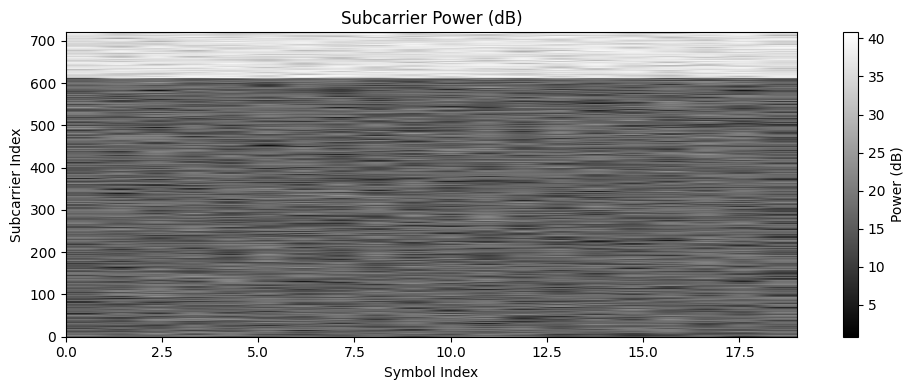

In [69]:
plot_subcarrier_power(full_power, ifft_size=720, num_symbols_actual=20)


In [70]:
def plot_autocorrelation(signal, max_lag=None):
    N = len(signal)
    if max_lag is None:
        max_lag = N // 2

    # Compute full autocorrelation (normalized)
    corr = np.correlate(signal, signal, mode='full')  # length: 2N - 1
    lags = np.arange(-N + 1, N)
    corr = corr / np.max(np.abs(corr))  # Normalize to max=1 (coeff mode)

    # Keep only positive lags
    positive_lags = lags >= 0
    lags_positive = lags[positive_lags][:max_lag]
    Rxx_positive = corr[positive_lags][:max_lag]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lags_positive, np.abs(Rxx_positive))
    plt.title('Autocorrelation of the Received Signal')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


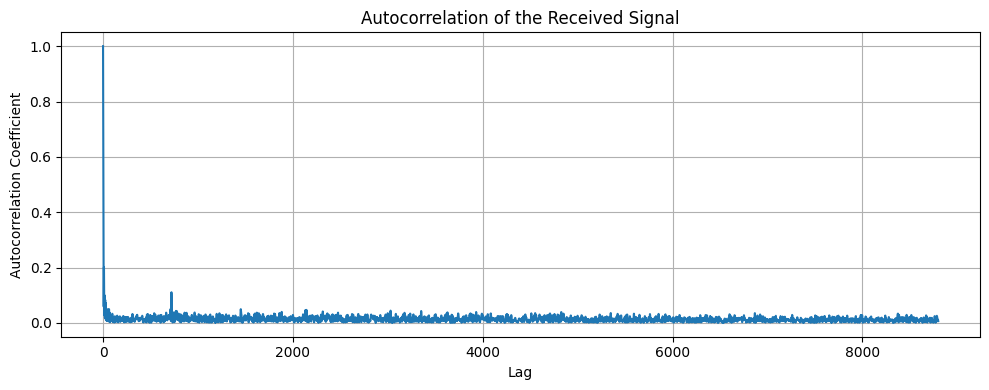

In [71]:
plot_autocorrelation(final_signal)


In [72]:
def plot_symmetric_power_spectrum(power_matrix, ifft_size):
    # Step 1: Average over all OFDM symbols
    avg_power = np.mean(power_matrix, axis=0)           # shape: (ifft_size,)
    avg_power_shifted = np.fft.fftshift(avg_power)      # shift DC to center

    # Step 2: Frequency axis symmetric around 0
    half = ifft_size // 2
    freq_axis = np.arange(-half, half)

    # Step 3: Plot
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis, avg_power_shifted, linewidth=1.2)
    plt.title('Symmetric Power Spectrum of OFDM')
    plt.xlabel('Subcarrier Index (centered)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




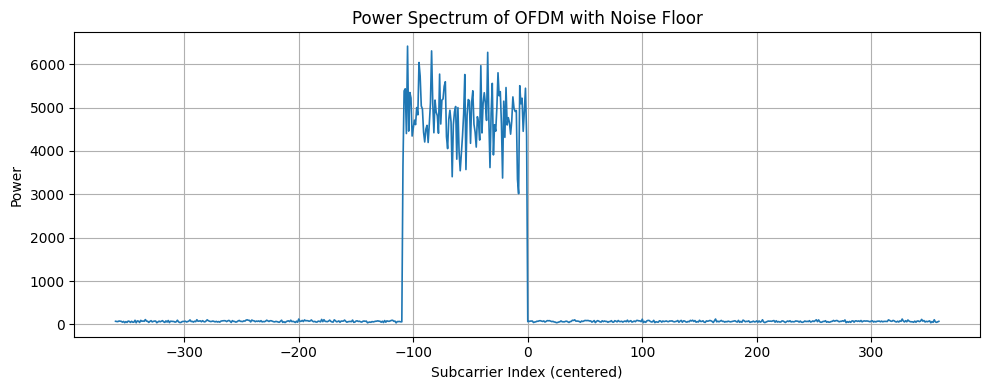

In [73]:
plot_average_power_spectrum(full_power, ifft_size=720)


In [74]:
def plot_constellation(X_fft, active_subcarriers):
    # Step 1: Extract symbols from active subcarriers (avoid DC, guard bands)
    rx_constellation = X_fft[:, active_subcarriers]  # shape: [num_symbols, num_active]

    # Step 2: Flatten to 1D array
    rx_symbols_flat = rx_constellation.flatten()

    # Step 3: Determine scaling for axis limits
    avg_power = np.mean(np.abs(rx_symbols_flat)**2)
    scale = 2 * np.sqrt(avg_power)

    # Step 4: Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
    plt.title('QPSK Constellation after OFDM Demodulation')
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-scale, scale])
    plt.ylim([-scale, scale])
    plt.tight_layout()
    plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


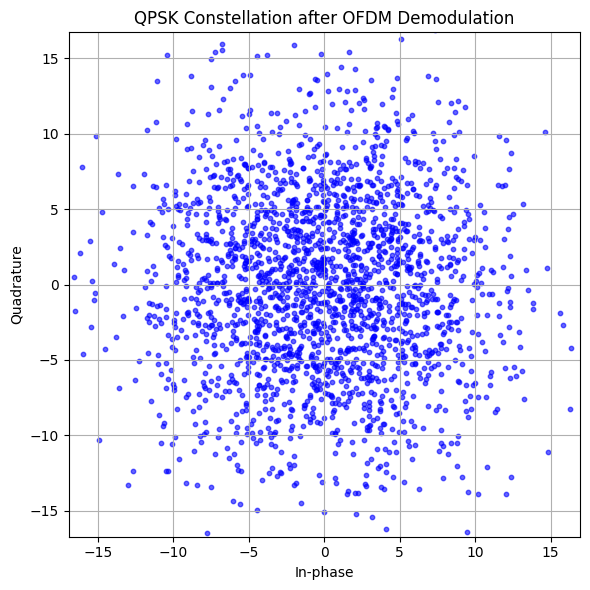

In [75]:
plot_constellation(X_fft, active_subcarriers)
